# Proyek Klasifikasi Gambar: https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset
- **Nama:** Naufal Nur Fahriza
- **Email:** naufalnurfahriza@gmail.com
- **ID Dicoding:** NurFahriza

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naufalnurfahriza","key":"ec6f7ab7dabebc9fd0600384aa1880de"}'}

In [4]:
!pip install -q kaggle

In [5]:
# Setup credential kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download dataset DermNet
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0


In [7]:
# Unzip dataset
!unzip -q rice-image-dataset.zip -d Rice_Image_Dataset

In [15]:
# Verifikasi dataset
print("Daftar folder:")
print(os.listdir("Rice_Image_Dataset"))

print("\nJumlah gambar per kategori:")
actual_data_path = "Rice_Image_Dataset/Rice_Image_Dataset"

if os.path.exists(actual_data_path):
    for folder in os.listdir(actual_data_path):
        folder_path = os.path.join(actual_data_path, folder)
        if os.path.isdir(folder_path):
            print(f"{folder}: {len(os.listdir(folder_path))} gambar")
else:
    print("Folder data tidak ditemukan di:", actual_data_path)

Daftar folder:
['Rice_Image_Dataset']

Jumlah gambar per kategori:
Karacadag: 15000 gambar
Basmati: 15000 gambar
Ipsala: 15000 gambar
Jasmine: 15000 gambar
Arborio: 15000 gambar


### Data Preprocessing

#### Split Dataset

In [18]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath = 'Rice_Image_Dataset/Rice_Image_Dataset'

file_name = []
labels = []
full_path = []

# Hanya proses folder yang valid (abaikan file teks)
valid_classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

for class_name in valid_classes:
    class_path = os.path.join(mypath, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            full_path.append(os.path.join(class_path, img_name))
            labels.append(class_name)
            file_name.append(img_name)

df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Verifikasi distribusi kelas
print("\nDistribusi data sebelum split:")
print(df['labels'].value_counts())


Distribusi data sebelum split:
labels
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64


In [19]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split ke train dan test (80:20)
# Hanya lakukan stratify jika semua kelas memiliki minimal 2 sampel
if all(count >= 2 for count in df['labels'].value_counts()):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    print("\nPeringatan: Stratifikasi diabaikan karena ada kelas dengan sampel < 2")

In [20]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [21]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('\ntrain size:', len(df_tr))
print('test size :', len(df_te))
print('\nDistribusi kelas di training set:')
print(df_tr['labels'].value_counts())
print('\nDistribusi kelas di test set:')
print(df_te['labels'].value_counts())


train size: 60000
test size : 15000

Distribusi kelas di training set:
labels
Basmati      12000
Ipsala       12000
Karacadag    12000
Arborio      12000
Jasmine      12000
Name: count, dtype: int64

Distribusi kelas di test set:
labels
Arborio      3000
Ipsala       3000
Karacadag    3000
Jasmine      3000
Basmati      3000
Name: count, dtype: int64


In [22]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('\nDistribusi setelah split:')
print(df_all.groupby(['set', 'labels']).size())


Distribusi setelah split:
set    labels   
test   Arborio       3000
       Basmati       3000
       Ipsala        3000
       Jasmine       3000
       Karacadag     3000
train  Arborio      12000
       Basmati      12000
       Ipsala       12000
       Jasmine      12000
       Karacadag    12000
dtype: int64


In [23]:
# Buat struktur folder baru
dataset_path = "rice_dataset_final/"
os.makedirs(dataset_path, exist_ok=True)

In [24]:
# Salin gambar ke folder baru sesuai set dan label
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']
    label = row['labels']
    subset = row['set']

    dest_folder = os.path.join(dataset_path, subset, label)
    os.makedirs(dest_folder, exist_ok=True)

    file_name = os.path.basename(file_path)
    dest_path = os.path.join(dest_folder, file_name)

    if not os.path.exists(dest_path):
        shutil.copy2(file_path, dest_path)

  0%|          | 0/75000 [00:00<?, ?it/s]

### Image Data Generator

## Modelling

In [25]:
# Define training and test directories
TRAIN_DIR = "rice_dataset_final/train/"
TEST_DIR = "rice_dataset_final/test/"

class_names = os.listdir(TRAIN_DIR)

print("📊 Jumlah gambar per kelas:")
print("\nTraining Set:")
for cls in class_names:
    cls_path = os.path.join(TRAIN_DIR, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images}")

print("\nTest Set:")
for cls in class_names:
    cls_path = os.path.join(TEST_DIR, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images}")

📊 Jumlah gambar per kelas:

Training Set:
  Karacadag: 12000
  Basmati: 12000
  Ipsala: 12000
  Jasmine: 12000
  Arborio: 12000

Test Set:
  Karacadag: 3000
  Basmati: 3000
  Ipsala: 3000
  Jasmine: 3000
  Arborio: 3000


In [26]:
# Buat objek ImageDataGenerator yang menormalkan gambar dan menyertakan validation split
datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.85, 1.15],
    validation_split=0.2
)

# Generator untuk data test
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training set
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator untuk validation set
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generator untuk test set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 48000 images belonging to 5 classes.
Found 12000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [38]:
# Define Transfer Learning Model with Sequential
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function (FIXED VERSION)
def lr_schedule(epoch):
    initial_lr = 0.001
    decay_rate = 0.9
    decay_steps = 1000

    # Perbaikan: Tambahkan pengecekan untuk menghindari division by zero
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    if steps_per_epoch == 0:  # Jika hasilnya 0, gunakan nilai default 1
        steps_per_epoch = 1

    epoch_decay = epoch // (decay_steps // steps_per_epoch) if (decay_steps // steps_per_epoch) != 0 else epoch
    return initial_lr * (decay_rate ** epoch_decay)

# Define the model architecture
def create_model():
    # Load MobileNetV2 as base model
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling=None
    )

    # Freeze the base model
    base_model.trainable = False

    # Build custom head
    model = Sequential([
      base_model,
      Dropout(0.5),
      Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer='l2'),
      GlobalAveragePooling2D(),
      Dense(256, activation='relu', kernel_regularizer='l2'),
      Dropout(0.3),
      Dense(len(class_names), activation='softmax')
    ])

    return model

# Create model
model = create_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,636,389 (10.06 MB)

 Trainable params: 378,405 (1.44 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    LearningRateScheduler(lr_schedule),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [41]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
)

#Calculate class weights
try:
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = dict(enumerate(class_weights))
    print("Class weights calculated successfully:", class_weights)
except Exception as e:
    print("Error calculating class weights, using None:", str(e))
    class_weights = None

# Train the model
try:
    print("\nTraining Info:")
    print(f"Samples: {train_generator.samples}")
    print(f"Batch size: {train_generator.batch_size}")
    print(f"Steps per epoch: {len(train_generator)}")

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=10,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
except Exception as e:
    print("\nTraining failed:", str(e))
    print("Possible solutions:")
    print("1. Reduce batch size (try 16 or 8)")
    print("2. Check if all images are valid")
    print("3. Verify your data directory structure")


# Load the best model (using modern .keras format)
if os.path.exists('best_model.keras'):
    model = tf.keras.models.load_model('best_model.keras')
    print("Best model loaded successfully")
else:
    print("No saved model found")

Class weights calculated successfully: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0)}

Training Info:
Samples: 48000
Batch size: 32
Steps per epoch: 1500
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9478 - loss: 0.3416 - precision: 0.9508 - recall: 0.9449

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.96158, saving model to best_model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 827s 545ms/step - accuracy: 0.9478 - loss: 0.3416 - precision: 0.9508 - recall: 0.9449 - val_accuracy: 0.9616 - val_loss: 0.1995 - val_precision: 0.9624 - val_recall: 0.9609 - learning_rate: 0.0010
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9580 - loss: 0.1994 - precision: 0.9594 - recall: 0.9569
Epoch 2: val_accuracy did not improve from 0.96158
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 777s 518ms/step - accuracy: 0.9580 - loss: 0.1994 - precision: 0.9594 - recall: 0.9569 - val_accuracy: 0.9578 - val_loss: 0.1849 - val_precision: 0.9591 - val_recall: 0.9558 - learning_rate: 9.0000e-04
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9594 - loss: 0.1851 - precision: 0.9609 - recall: 0.9581
Epoch 3: val_accuracy improved from 0.96158 to 0.96858, saving model to best_model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 829s 553ms/step - accuracy

## Evaluasi dan Visualisasi

In [42]:
# Evaluasi di test set
print("\n⚙️ Evaluating on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"\n📊 Test Metrics:")
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Loss: {test_loss:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")


⚙️ Evaluating on test set...
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 117s 7ms/step - accuracy: 0.9858 - loss: 0.0896 - precision: 0.9859 - recall: 0.9858

📊 Test Metrics:
Accuracy: 97.15%
Loss: 0.1245
Precision: 0.9718
Recall: 0.9713


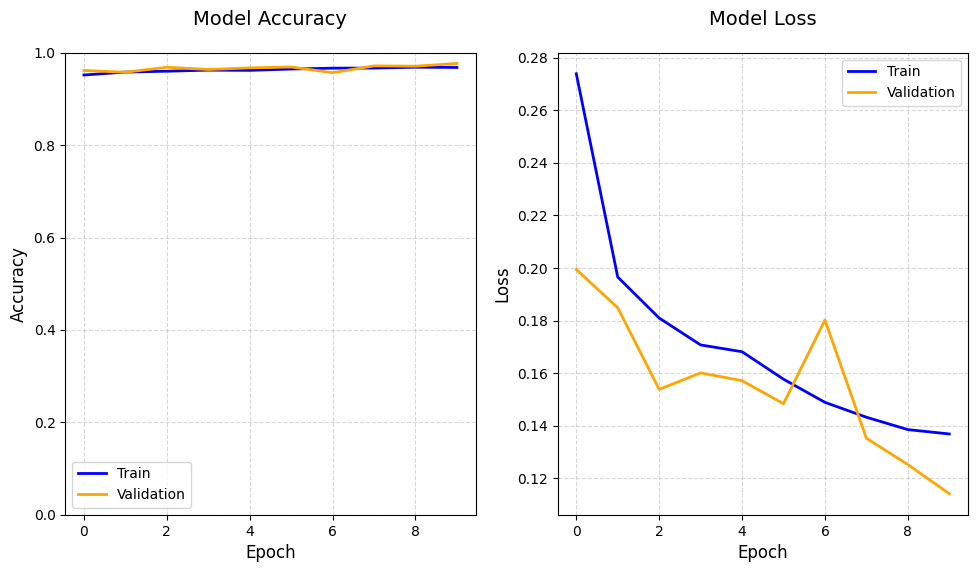

In [43]:
# Plot grafik akurasi & loss
plt.figure(figsize=(18, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linewidth=2)
plt.title('Model Accuracy', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', color='orange', linewidth=2)
plt.title('Model Loss', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


In [44]:
# Prediksi data test
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification Report
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 98s 6ms/step

📝 Classification Report:
              precision    recall  f1-score   support

     Arborio     0.9151    0.9947    0.9532      3000
     Basmati     0.9938    0.9653    0.9794      3000
      Ipsala     0.9997    0.9933    0.9965      3000
     Jasmine     0.9590    0.9893    0.9739      3000
   Karacadag     0.9982    0.9147    0.9546      3000

    accuracy                         0.9715     15000
   macro avg     0.9731    0.9715    0.9715     15000
weighted avg     0.9731    0.9715    0.9715     15000



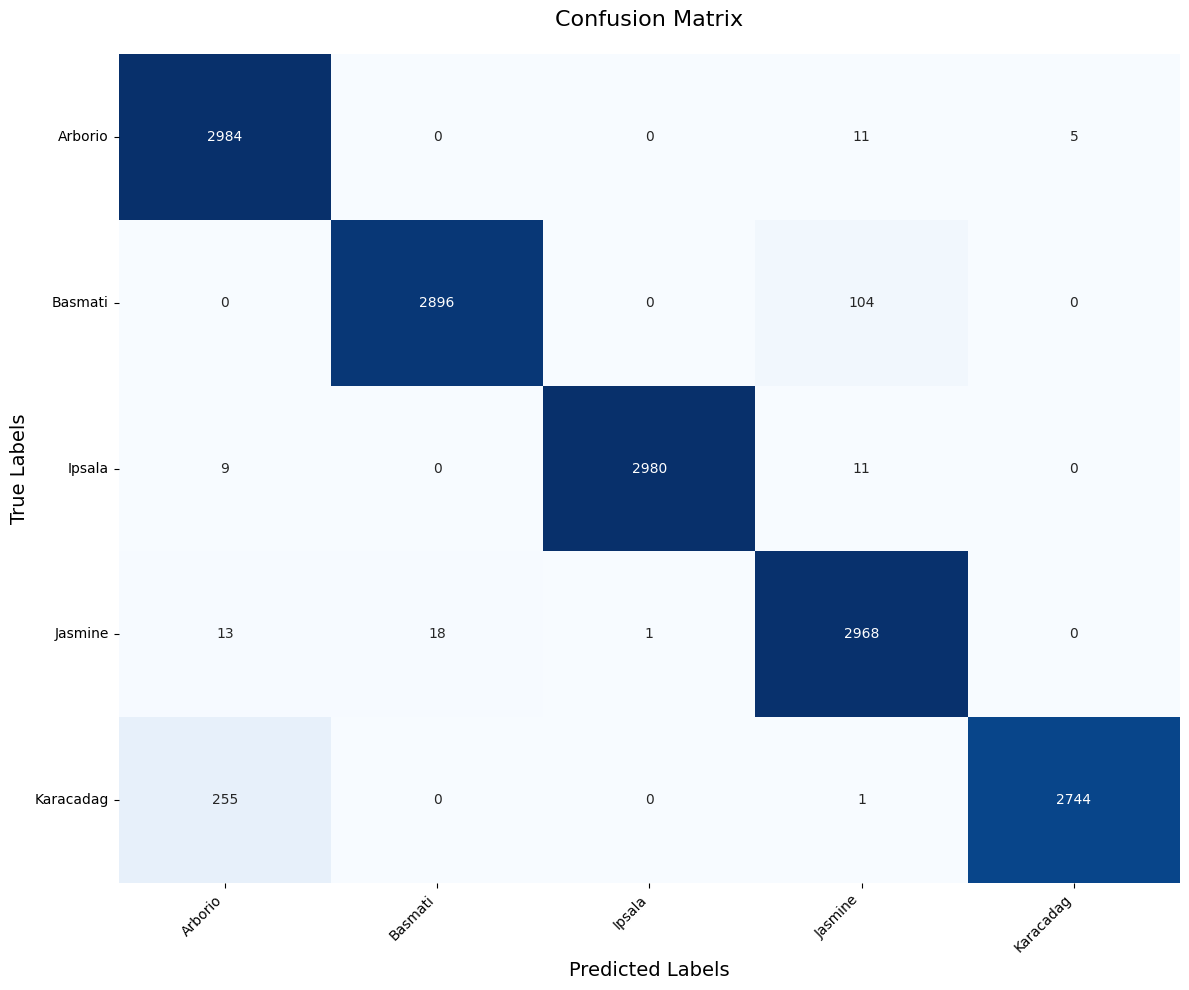

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

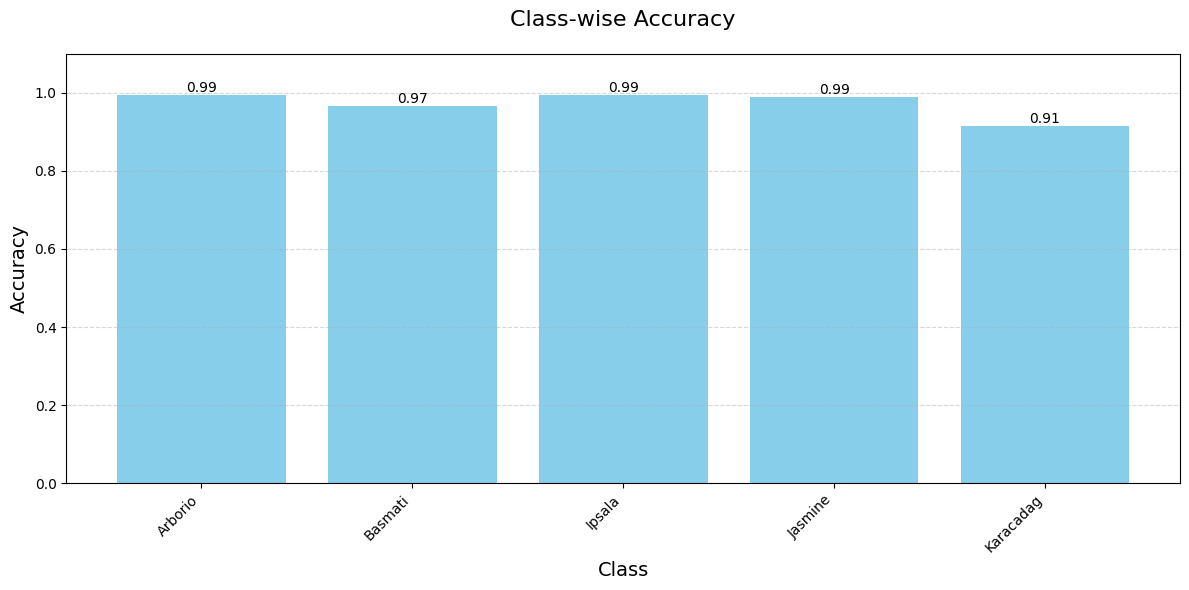

In [46]:
# Class-wise Accuracy
correct = np.zeros(len(class_names))
total = np.zeros(len(class_names))

for i in range(len(y_true)):
    class_idx = y_true[i]
    total[class_idx] += 1
    if y_true[i] == y_pred[i]:
        correct[class_idx] += 1

class_accuracy = correct / total

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue')
plt.title('Class-wise Accuracy', fontsize=16, pad=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Add accuracy values on top of bars
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

## Konversi Model

In [47]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [48]:
# Model Export Function
def export_model(model, class_names):
    # Create directories
    os.makedirs('saved_model', exist_ok=True)
    os.makedirs('tflite', exist_ok=True)
    os.makedirs('tfjs_model', exist_ok=True)

    # 1. Save in SavedModel format (for TF Serving/Cloud)
    tf.saved_model.save(model, 'saved_model/my_model')  # Corrected this line

    # 2. Convert to TFLite (for mobile devices)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('tflite/model.tflite', 'wb') as f:
        f.write(tflite_model)

    # Save labels for TFLite
    with open('tflite/labels.txt', 'w') as f:
        f.write('\n'.join(class_names))

    # 3. Convert to TFJS (for web)
    try:
        import tensorflowjs as tfjs
        tfjs.converters.save_keras_model(model, 'tfjs_model')
    except ImportError:
        print("⚠️ tensorflowjs not installed. Run: pip install tensorflowjs")

    print("✅ Model exported in all formats")

# Export the model
print("\n🛠️ Exporting model...")
export_model(model, class_names)


🛠️ Exporting model...
Saved artifact at '/tmp/tmp76x09y57'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139523944585488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944589136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944587024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944588176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944579536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944585680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944583568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944584336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944582992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139523944579920: TensorSpec(shape=(), dtype=tf.resource, nam

failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model exported in all formats


In [49]:
#Generate requirements.txt
print("\n📦 Generating requirements.txt...")
!pip freeze > requirements.txt

print("\n✅ All done! Model exported in all required formats.")


📦 Generating requirements.txt...

✅ All done! Model exported in all required formats.


In [50]:
!zip -r submission.zip tfjs_model/ tflite/ saved_model/ requirements.txt

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 11%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tflite/ (stored 0%)
  adding: tflite/labels.txt (stored 0%)
  adding: tflite/model.tflite (deflated 9%)
  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 92%)
  adding: saved_model/my_model/fingerprint.pb (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 77%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: requirements.txt (deflated 57%)


## Inference (Optional)